<a href="https://colab.research.google.com/github/CeesGniewyk/Recommender-Systems/blob/master/Assignment_4_practical_Group_4_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

## Importing Packages

In [0]:
from keras.layers import Lambda, Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, BatchNormalization, Dropout
from keras.models import Model, load_model, Sequential
from keras.datasets import mnist
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
import math
import numpy as np
import matplotlib.pyplot as plt
import os

## Mounting Google Drive and Associated Tools

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import pickle
def load_model(file_name):

    f = open(file_name, 'rb')
    read_file = pickle.load(f)
    print("file loaded")
    f.close()

    return read_file

def save_model(file_name, data):

    f = open(file_name, 'wb')
    pickle.dump(data, f)
    print(" file saved")
    f.close()

In [0]:
cd /content/gdrive/My Drive/Colab Notebooks/"Assignment 4"/Models

/content/gdrive/My Drive/Colab Notebooks/Assignment 4/Models


# Question 1: Variational Autoencoder
**Make sure you have read the theoretical assignment, and answered the questions there, before working on this practical assignment.**

In this task, we will implement a Variational Autoencoder (VAE) step by step, using the model and results from the theoretical assignment. Some code is already provided, the task is to fill in the gaps.

### Data
We will train a VAE for the MNIST data. This code loads the data, and increases the canvas size to 32x32 by padding zeros. This makes it easier to design convolutional autoencoder architectures with striding or pooling/upsampling.

In [0]:
# MNIST dataset
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()

# normalise
x_train_mnist = x_train_mnist.astype('float32') / 255
x_test_mnist = x_test_mnist.astype('float32') / 255

# change shape: (n, 28, 28) -> (n, 28, 28, 1)
x_train_mnist = x_train_mnist.reshape(x_train_mnist.shape + (1,))
x_test_mnist = x_test_mnist.reshape(x_test_mnist.shape + (1,))

# pad zeros to obtain canvas size of 32x32, i.e. shape is now (n, 32, 32, 1)
x_train_mnist = np.pad(x_train_mnist, pad_width=((0, 0), (2, 2), (2, 2), (0, 0)), mode="constant", constant_values=0)
x_test_mnist = np.pad(x_test_mnist, pad_width=((0, 0), (2, 2), (2, 2), (0, 0)), mode="constant", constant_values=0)

# get height, width, and depth values
height, width, depth = x_train_mnist.shape[1:]

## Task 1.1: Encoder architecture
**(a)** *Choose and implement a suitable architecture for the encoder. The encoder should have two outputs, which we will interpret as the mean and log variance of the approximate posterior distribution $q(z|x)$ (a Gaussian, as defined in the theoretical assignment). In this task, use a latent space dimension of 2 such that we can easily plot the latent space.*

In [0]:
# network parameters
input_shape = (height, width, depth)
latent_dim_mnist = 2


# VAE model = encoder + decoder
# build encoder model
x_in = Input(shape=input_shape, name='encoder_input')

# conv block 1
h = Conv2D(filters=64, kernel_size=(3, 3), padding="same",
           activation='relu')(x_in)                    # (32, 32, 1)  -> (32, 32, 64)
h = MaxPooling2D(pool_size=(2, 2), padding="same")(h)  # (32, 32, 64) -> (16, 16, 64)
h = BatchNormalization()(h)                            # no change

# conv block 2
h = Conv2D(filters=128, kernel_size=(3, 3), padding="same",
           activation='relu')(h)                       # (16, 16, 64)  -> (16, 16, 128)
h = MaxPooling2D(pool_size=(2, 2), padding="same")(h)  # (16, 16, 128) -> (8, 8, 128)
h = BatchNormalization()(h)                            # no change

# dense layers
h = Flatten()(h)                                       # (8, 8, 128) -> (8*8*128,)
h = Dense(256, activation="relu")(h)                   # (8*8*128,)  -> (256,)
h = BatchNormalization()(h)                            # no change
h = Dense(128, activation="relu")(h)                   # (256,) -> (128,)
h = BatchNormalization()(h)                            # no change

z_mean = Dense(latent_dim_mnist, name='z_mean')(h)  # mean parameter of q(z|x)
z_log_var = Dense(latent_dim_mnist, name='z_log_var')(h)  # log of variance parameter of q(z|x)

# instantiate encoder model
mnist_vae_encoder = Model(x_in, [z_mean, z_log_var], name='encoder')
mnist_vae_encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 32, 64)   640         encoder_input[0][0]              
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 16, 16, 64)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 16, 16, 64)   256         max_pooling2d_3[0][0]            
__________________________________________________________________________________________________
conv2d_6 (

**(b)** *Motivate your choice of architecture.*

**Answer:**

The architecture of the model is based on convolutional autoencoder, this architecute is also used in the practical and has yielded results. <br>
Since we're dealing with image data, there is surely spatial correlation, therefore using convolutional blocks seems intuitive.

**(c)** *What is the reason to model the logarithm of the variance, instead of the variance (or standard deviation) itself?*

**Answer:**

 If we would directly output the values, the network can only output numbers in the range 0-1 while using a logaritmic scale, a wider range of numbers can be outputted and later compressed (similar to using softmax)

## Task 1.2: Decoder architecture
**(a)** *Choose and implement a suitable architecture for the decoder. Input is a sample of latent variables, the output represents the parameters of the generative distribution $p(x|z)$, i.e. the mean of a Gaussian distribution (for continuous data) or Bernoulli distribution (for binary data).*

In [0]:
# build decoder model
z_in = Input(shape=(latent_dim_mnist,), name='z_in')

h = Dense(128,activation="relu")(z_in)                 # (32,) -> (128,) (encoding dimension)
h = BatchNormalization()(h)                                 # no change
h = Dense(256,activation="relu")(h)                         # (128, -> (256,)
h = BatchNormalization()(h)                                 # no change
h = Dense(8*8*128,activation="relu")(h)                     # (256,)     -> (8*8*128,)
h = Reshape((8,8,128))(h)                                   # (8*8*128,) -> (8, 8, 128)
                                                            
h = BatchNormalization()(h)                                 # no change
h = UpSampling2D((2, 2))(h)                                 # (8, 8, 128  ) -> (16, 16, 128)
h = Conv2D(filters=64, kernel_size=(3, 3), padding="same",
           activation='relu')(h)                            # (16, 16, 128) -> (16, 16, 64)
                                                            
h = BatchNormalization()(h)                                 # no change
h = UpSampling2D((2, 2))(h)                                 # (16, 16, 64) -> (32, 32, 64)
dec_out = Conv2D(filters=1, kernel_size=(3, 3), padding="same",
           activation='sigmoid')(h)    

# instantiate decoder model
mnist_vae_decoder = Model(z_in, dec_out, name='decoder')
mnist_vae_decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_in (InputLayer)            (None, 2)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               384       
_________________________________________________________________
batch_normalization_13 (Batc (None, 128)               512       
_________________________________________________________________
dense_9 (Dense)              (None, 256)               33024     
_________________________________________________________________
batch_normalization_14 (Batc (None, 256)               1024      
_________________________________________________________________
dense_10 (Dense)             (None, 8192)              2105344   
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 128)         0         
__________

**(b)** *Motivate your choice of architecture.*

**Answer:**

In research it's rarely found to have a different decoder than encoder architecture. The encoder architecture is mirrored in the decoder <br>
Instead of dealing with the so called "checkers board" problem that happens when there is striding involved in the convolutional layers, this is mitigated by using upsampling and not applying striding.

## Load Trained model
Uncomment after first run

In [0]:
# mnist_vae_encoder = load_model("mnist_vae_encoder")
# mnist_vae_decoder = load_model("mnist_vae_decoder")

# x_in = mnist_vae_encoder.input
# z_mean, z_log_var = mnist_vae_encoder.output
# latent_dim = int(z_mean.shape[1])

## Task 1.3: Reparametrisation trick
*To implement sampling with the reparametrisation trick, we will define a custom lambda layer. It takes the mean and log variance of $q(z|x)$ as input, and outputs a sample from $q(z|x)$. This is done by first sampling from a standard Gaussian (Normal) distribution, and then applying the proper transformation to obtain a sample from $q(z|x)$ with the given mean and variance. Implement this transformation.*

In [0]:
def sampling(args):
    """Reparametrisation trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of q(z|x)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch_dim = K.shape(z_mean)[0]
    z_dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch_dim, z_dim))
    
    #### INSERT CODE HERE
    return z_mean + K.exp(z_log_var) * epsilon
    ####


# use reparametrisation trick to push the sampling out as input
z = Lambda(sampling, name='z')([z_mean, z_log_var])


# instantiate full VAE model
x_mean = mnist_vae_decoder(z)
mnist_vae = Model(x_in, x_mean, name='vae')
mnist_vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 32, 64)   640         encoder_input[0][0]              
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 16, 16, 64)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 16, 16, 64)   256         max_pooling2d_3[0][0]            
__________________________________________________________________________________________________
conv2d_6 (

## Task 1.4: Loss function
*Now we define the loss function, which you have derived in the theoretical part of the assignment. Note: we wish to maximise the ELBO, but Keras formulates training objectives as a loss function to minimise, so the loss function is the negative ELBO:*
$-\mathbb{E}_{q_\phi(z|x)} [\log p_\theta(x|z)] + KL(q_\phi(z|x) || p(z))$.

*We split this into two terms, the reconstruction loss and the KL loss.*


### Reconstruction loss
*We start with the first term: $-\mathbb{E}_{q_\phi(z|x)} [\log p_\theta(x|z)]$.*

*We approximate the expectation with a single Monte Carlo sample (using the reparametrisation trick such that the loss function is differentiable), which we can readily obtain from the sampling layer of our encoder model (output `z`). So all you need to implement is the loss function $-\log p_\theta(x|z_{sample})$. You've derived the formula for this in the theoretical part of the assignment, for both a Bernoulli distribution (for discrete data) and a Gaussian distribution with fixed standard deviation (for continuous data). Implement both versions here. Choose a suitable standard deviation value for the Gaussian.*

### KL loss
*The second term of the loss is the KL Divergence $KL(q_\phi(z|x) || p(z))$, which as we saw has a closed form for our choice of posterior and prior (both Gaussians):
$ \frac{1}{2} \sum_{k=1}^K (m_k^2 + s_k^2 - \log s_k^2 - 1)$ (see the theoretical part of the assignment for explanation of the notations). Implement it here.*


##### Implementation notes:
* Always use functions from the Keras backend (available through `from keras import backend as K`) for Tensor operations in your loss function. This way, Keras can perform automatic differentiation to compute the gradients for training. E.g. `K.sum(), K.square(), K.exp()`. You can use operators such as `+` and `*`, they will automatically convert to Tensor operations.
* Make sure to use `K.flatten(x_in)` and `K.flatten(x_mean)` whenever you need them in your loss functions, don't use `x_in` or `x_mean`. The `(height, width, depth)` structure of the data is only needed for convolutional layers, but not in the loss function.
* Note that the formulas you derived in the theoretical assignment are for a single data point or latent variable. Keras however expects a batch of data points or latent variables, so the first dimension in a Tensor is always the batch dimension. For most operations, broadcasting will automatically make computations operate on each data point in a batch individually, but for operations such as `K.sum` you need to make sure you specify the correct axis.

In [0]:
from keras.losses import mse
# reconstruction loss
gen_model = "gaussian"  # "bernoulli" or "gaussian"

if gen_model == "bernoulli":
    #### insert code here
#     reconstruction_loss = ...
    reconstruction_loss = -(binary_crossentropy(K.flatten(x_in), K.flatten(x_mean)))
    ####
elif gen_model == "gaussian":
    #### insert code here
    dec_std = 1 / math.sqrt(2)
    # We are not using the dec_std, but instead apply mse directly
    reconstruction_loss = mse(K.flatten(x_in), K.flatten(x_mean))
    reconstruction_loss *= 1024
    ####


# KL loss
#### insert code here
kl_loss = K.square(z_mean) + K.exp(z_log_var) - z_log_var - 1
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= 0.5
####

# combine both losses
mnist_vae_loss = reconstruction_loss + kl_loss
# we use .add_loss instead of including a loss function in .compile, such that
#     we don't have to supply any "true labels", as training is unsupervised
mnist_vae.add_loss(mnist_vae_loss)
mnist_vae.compile(optimizer='adam')
mnist_vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 32, 64)   640         encoder_input[0][0]              
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 16, 16, 64)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 16, 16, 64)   256         max_pooling2d_3[0][0]            
__________________________________________________________________________________________________
conv2d_6 (

## Task 1.5: Training & Saving Model
**Comment this after running it once <br>**
*Train the model for 50 epochs with batch size 100. Choose whether to use the Bernoulli or Gaussian generative distribution. On Google Colab, go to Edit > Notebook settings and make sure to select "GPU" as hardware accelerator.*

In [0]:
batch_size = 100
epochs = 20

# train the autoencoder
mnist_vae.fit(x_train_mnist,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test_mnist, None))

save_model("mnist_vae_encoder",mnist_vae_encoder)
save_model("mnist_vae_decoder",mnist_vae_decoder)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 16s 270us/step - loss: 56.3795 - val_loss: 48.9441
Epoch 2/20
60000/60000 [==============================] - 14s 231us/step - loss: 43.1622 - val_loss: 44.2528
Epoch 3/20
60000/60000 [==============================] - 14s 231us/step - loss: 40.1895 - val_loss: 40.1246
Epoch 4/20
60000/60000 [==============================] - 14s 232us/step - loss: 38.4257 - val_loss: 37.1148
Epoch 5/20
60000/60000 [==============================] - 14s 233us/step - loss: 37.1203 - val_loss: 36.3401
Epoch 6/20
60000/60000 [==============================] - 14s 234us/step - loss: 37.5061 - val_loss: 37.3042
Epoch 7/20
60000/60000 [==============================] - 14s 233us/step - loss: 36.4019 - val_loss: 35.7493
Epoch 8/20
60000/60000 [==============================] - 14s 234us/step - loss: 35.6763 - val_loss: 34.7836
Epoch 9/20
60000/60000 [==============================] - 14s 233us/step - los

## Evaluating Functions

*Use the following functions to generate plots of the latent space (note that they only work for a 2-dimensional latent space).*

*The first plot shows the mean representations in latent space for data points from the test set. Although VAEs are unsupervised, we do have label information for the MNIST data, so we can use this give data points a different colour depending on their label.*

*The second plot takes linearly spaced coordinates in latent space, decodes them into data space representations, and plots them in a grid according to the latent space coordinates. So each of the images are generated, not reconstructed from data.*

In [0]:
batch_size = 100

def plot_results(encoder, decoder,
                 x_test, y_test,
                 batch_size=128):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments
        encoder (keras Model): encoder model
        decoder (keras Model): decoder model
        x_test (np.array): test data
        y_test (np.array): test labels
        batch_size (int): prediction batch size
    """

    # display a 2D plot of the digit classes in the latent space
    z_mean, _ = encoder.predict(x_test_mnist,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = x_test_mnist.shape[1]  # assume square images, i.e. height == width
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            x_decoded = np.reshape(x_decoded, (x_decoded.shape[0], -1))
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

In [0]:
def drawMeanForLabel(encoder, decoder, x_test, label, drawFigure=False, labels = '0 1 2 3 4 5 6 7 8 9'.split()):
    z_mean, _ = encoder.predict(x_test, batch_size=128)
    latent_dimensions = z_mean.shape[1]
    means = np.empty(latent_dimensions).reshape((1,latent_dimensions))
    for dim in range(latent_dimensions):

        means[0][dim] = np.median(z_mean[y_test_mnist == label][:, dim])
    figure = decoder.predict(means)
    figure = np.reshape(figure, (figure.shape[0], -1))
    figure = figure[0].reshape(x_test.shape[1], x_test.shape[1])
    if drawFigure:
        plt.figure(figsize=(10, 10))
        plt.title(labels[label])
        plt.imshow(figure, cmap='Greys_r')
        plt.show()
    return figure
    
def plot_examples_vae_mnist(encoder,decoder):
    n = 10
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(drawMeanForLabel(encoder, decoder, x_test_mnist, i))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

## Show results

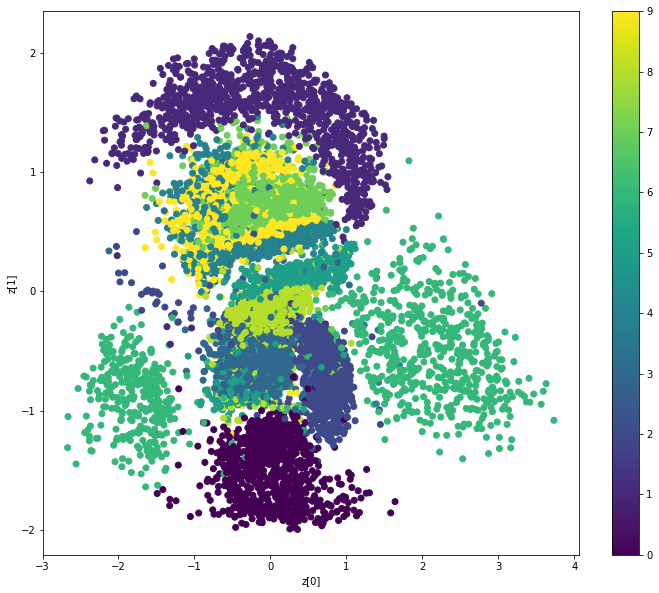

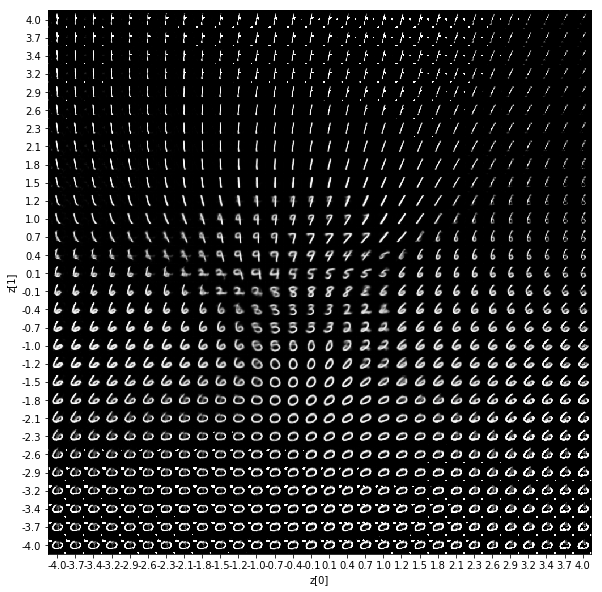

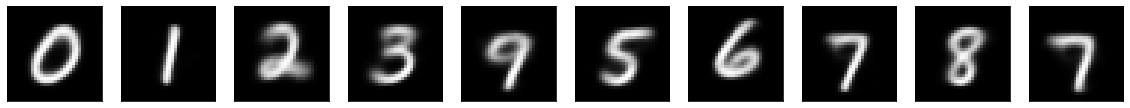

In [0]:
# loading previously trained model and plot results
plot_results(mnist_vae_encoder,mnist_vae_decoder,
             x_test_mnist, y_test_mnist,
             batch_size=batch_size)
plot_examples_vae_mnist(mnist_vae_encoder,mnist_vae_decoder)

*These latent space plots can give an insight into the (latent) representations that are learned by the VAE. Evaluate what you see:*

**(a)** *Did you successfully train a generative model for this data? Motivate your answer.*



**Answer:**

From the latens space plot it can be seen that there is a lot of noise on the outside, which intuitively could be due to a too strong KL loss in the loss function. However this is not the case. From the median plots it can be seen that the values for the numbers are estimated quite correctly. It was expected that for such a short training time and no overtuning of parameters the difficult digits such as 7 and 9 are hard to distinguish.

**(b)** *Discuss how the latent space is populated by the test data. What happens in "gaps" in the latent space? I.e. areas in latent space near the origin (so with high prior likelihood) but without any data points being mapped to them. What do images generated from such latent points look like?*

**Answer:**

The latent space is such the model tries to populate it evenly,  the empty spaces in between will became a mesh between multiple digits. That is also how they will be represented

# Question 2: FashionMNIST VAE, semi-supervised learning

In this question, we will investigate the usefulness of VAE latent representations in semi-supervised learning. Since the VAE is an unsupervised method, we don't need any labels to learn latent representations. Often, it is easy to obtain a lot of unlabelled data, but labelling this data is expensive. Thus, methods that can leverage unsupervised training to learn a supervised goal (such as classification) may be very powerful. This is the idea behind semi-supervised learning.

You will evaluate this on the FashionMNIST dataset. Although all labels are available for this dataset, we can "hide" some labels from a model, simply by not using all of them.

Besides representations learned with a VAE, you will also compare with another representation learning method: a denoising autoencoder.

## Task 2.1: Unsupervised training
**(a)** *Train two representation learning methods on the FashionMNIST dataset; a variational autoencoder (VAE) and a denoising autoencoder. Choose a suitable architecture, and encoding/latent dimension (hint: for good results a dimension of 2 will likely be too small). For fairness, use similar architectures for each of the models.*

*Use each of the models to obtain encoded representations for the full dataset (training and test set).*

**(b)** *Motivate your architectural choices.*

**Answer:**

Since we're dealing with image data, it makes sense to use a convolutional auto-encoder. The architecture used in practical 6 is a good starting point. This contains 2 convolutional blocks plus a dense layer. For the Denoising autoencoder a dense layer of 128 is chosen, while the VAE uses a latent dimension of 4. These result in decent representations, as can be seen in the following images and tasks.

### Data

In [0]:
from keras.datasets import fashion_mnist
# Fashion MNIST dataset
(x_train_fash_mnist, y_train_fash_mnist), (x_test_fash_mnist, y_test_fash_mnist) = fashion_mnist.load_data()

# normalise
x_train_fash_mnist = x_train_fash_mnist.astype('float32') / 255
x_test_fash_mnist = x_test_fash_mnist.astype('float32') / 255

# change shape: (n, 28, 28) -> (n, 28, 28, 1)
x_train_fash_mnist = x_train_fash_mnist.reshape(x_train_fash_mnist.shape + (1,))
x_test_fash_mnist = x_test_fash_mnist.reshape(x_test_fash_mnist.shape + (1,))

# pad zeros to obtain canvas size of 32x32, i.e. shape is now (n, 32, 32, 1)
x_train_fash_mnist = np.pad(x_train_fash_mnist, pad_width=((0, 0), (2, 2), (2, 2), (0, 0)), mode="constant", constant_values=0)
x_test_fash_mnist = np.pad(x_test_fash_mnist, pad_width=((0, 0), (2, 2), (2, 2), (0, 0)), mode="constant", constant_values=0)

# get height, width, and depth values
height, width, depth = x_train_fash_mnist.shape[1:]
####

4423680/4422102 [==============================] - 1s 0us/step


### Variational Autoencoder

#### Encoder Architecture

In [0]:
# network parameters
input_shape = (height, width, depth)
latent_dim_fash_mnist = 4


# VAE model = encoder + decoder
# build encoder model
x_in = Input(shape=input_shape, name='encoder_input')

# conv block 1
h = Conv2D(filters=64, kernel_size=(3, 3), padding="same",
           activation='relu')(x_in)                    # (32, 32, 1)  -> (32, 32, 64)
h = MaxPooling2D(pool_size=(2, 2), padding="same")(h)  # (32, 32, 64) -> (16, 16, 64)
h = BatchNormalization()(h)                            # no change

# conv block 2
h = Conv2D(filters=128, kernel_size=(3, 3), padding="same",
           activation='relu')(h)                       # (16, 16, 64)  -> (16, 16, 128)
h = MaxPooling2D(pool_size=(2, 2), padding="same")(h)  # (16, 16, 128) -> (8, 8, 128)
h = BatchNormalization()(h)                            # no change

# dense layers
h = Flatten()(h)                                       # (8, 8, 128) -> (8*8*128,)
h = Dense(256, activation="relu")(h)                   # (8*8*128,)  -> (256,)
h = BatchNormalization()(h)                            # no change
h = Dense(128, activation="relu")(h)                   # (256,) -> (128,)
h = BatchNormalization()(h)                            # no change


z_mean = Dense(latent_dim_fash_mnist, name='z_mean')(h)  # mean parameter of q(z|x)
z_log_var = Dense(latent_dim_fash_mnist, name='z_log_var')(h)  # log of variance parameter of q(z|x)

# instantiate encoder model
fash_mnist_vae_encoder = Model(x_in, [z_mean, z_log_var], name='encoder')
fash_mnist_vae_encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 32, 32, 64)   640         encoder_input[0][0]              
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 16, 16, 64)   0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 16, 16, 64)   256         max_pooling2d_5[0][0]            
__________________________________________________________________________________________________
conv2d_10 

#### Decoder Architecture

In [0]:
# build decoder model
z_in = Input(shape=(latent_dim_fash_mnist,), name='z_in')

h = Dense(128,activation="relu")(z_in)                 # (32,) -> (128,) (encoding dimension)
h = BatchNormalization()(h)                                 # no change
h = Dense(256,activation="relu")(h)                         # (128, -> (256,)
h = BatchNormalization()(h)                                 # no change
h = Dense(8*8*128,activation="relu")(h)                     # (256,)     -> (8*8*128,)
h = Reshape((8,8,128))(h)                                   # (8*8*128,) -> (8, 8, 128)
                                                            
h = BatchNormalization()(h)                                 # no change
h = UpSampling2D((2, 2))(h)                                 # (8, 8, 128  ) -> (16, 16, 128)
h = Conv2D(filters=64, kernel_size=(3, 3), padding="same",
           activation='relu')(h)                            # (16, 16, 128) -> (16, 16, 64)
                                                            
h = BatchNormalization()(h)                                 # no change
h = UpSampling2D((2, 2))(h)                                 # (16, 16, 64) -> (32, 32, 64)
dec_out = Conv2D(filters=1, kernel_size=(3, 3), padding="same",
           activation='sigmoid')(h)    

# instantiate decoder model
fash_mnist_vae_decoder = Model(z_in, dec_out, name='decoder')
fash_mnist_vae_decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_in (InputLayer)            (None, 4)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               640       
_________________________________________________________________
batch_normalization_21 (Batc (None, 128)               512       
_________________________________________________________________
dense_14 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_22 (Batc (None, 256)               1024      
_________________________________________________________________
dense_15 (Dense)             (None, 8192)              2105344   
_________________________________________________________________
reshape_3 (Reshape)          (None, 8, 8, 128)         0         
__________

#### Load Trained model
Uncomment after first run

In [0]:
# fash_mnist_vae_encoder = load_model("fash_mnist_vae_encoder")
# fash_mnist_vae_decoder = load_model("fash_mnist_vae_decoder")

# x_in = fash_mnist_vae_encoder.input
# z_mean, z_log_var = fash_mnist_vae_encoder.output
# latent_dim = int(z_mean.shape[1])

#### Reparametrisation Trick

In [0]:
def sampling(args):
    """Reparametrisation trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of q(z|x)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch_dim = K.shape(z_mean)[0]
    z_dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch_dim, z_dim))
    
    #### INSERT CODE HERE
    return z_mean + K.exp(z_log_var) * epsilon
    ####


# use reparametrisation trick to push the sampling out as input
z = Lambda(sampling, name='z')([z_mean, z_log_var])


# instantiate full VAE model
x_mean = fash_mnist_vae_decoder(z)
fash_vae = Model(x_in, x_mean, name='vae')
fash_vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 32, 32, 64)   640         encoder_input[0][0]              
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 16, 16, 64)   0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 16, 16, 64)   256         max_pooling2d_5[0][0]            
__________________________________________________________________________________________________
conv2d_10 

#### Loss Function
This contains the reconstruction loss and KL_loss

In [0]:
from keras.losses import mse
# reconstruction loss
gen_model = "gaussian"  # "bernoulli" or "gaussian"

if gen_model == "bernoulli":
    reconstruction_loss = -(binary_crossentropy(K.flatten(x_in), K.flatten(x_mean)))
elif gen_model == "gaussian":
    dec_std = 1 / math.sqrt(2)
    reconstruction_loss = mse(K.flatten(x_in), K.flatten(x_mean))
    reconstruction_loss *= 1024


kl_loss = K.square(z_mean) + K.exp(z_log_var) - z_log_var - 1
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= 0.5


# combine both losses
fash_vae_loss = reconstruction_loss + kl_loss
# we use .add_loss instead of including a loss function in .compile, such that
#     we don't have to supply any "true labels", as training is unsupervised
fash_vae.add_loss(fash_vae_loss)
fash_vae.compile(optimizer='adam')

#### Training & Saving Model

In [0]:
batch_size = 100
epochs = 30

# train the autoencoder
fash_vae.fit(x_train_fash_mnist,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test_fash_mnist, None))

save_model("fash_mnist_vae_encoder",fash_mnist_vae_encoder)
save_model("fash_mnist_vae_decoder",fash_mnist_vae_decoder)

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 17s 283us/step - loss: 36.3101 - val_loss: 26.7726
Epoch 2/30
60000/60000 [==============================] - 14s 237us/step - loss: 24.4731 - val_loss: 23.3570
Epoch 3/30
60000/60000 [==============================] - 14s 237us/step - loss: 23.1972 - val_loss: 22.0160
Epoch 4/30
60000/60000 [==============================] - 14s 237us/step - loss: 22.8413 - val_loss: 22.5345
Epoch 5/30
60000/60000 [==============================] - 14s 236us/step - loss: 22.2094 - val_loss: 21.1367
Epoch 6/30
60000/60000 [==============================] - 14s 236us/step - loss: 21.7951 - val_loss: 21.2314
Epoch 7/30
60000/60000 [==============================] - 14s 236us/step - loss: 21.5617 - val_loss: 21.4701
Epoch 8/30
60000/60000 [==============================] - 14s 235us/step - loss: 21.4809 - val_loss: 22.4996
Epoch 9/30
60000/60000 [==============================] - 14s 237us/step - los

### Denoising Autoencoder

#### Adding noise
We obtain a noisy version of our data by adding Gaussian (normal) noise to each pixel, and clipping pixel values between 0 and 1.

In [0]:
noise_factor = 0.5
x_train_fash_mnist_noisy = x_train_fash_mnist + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_fash_mnist.shape) 
x_test_fash_mnist_noisy = x_test_fash_mnist + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test_fash_mnist.shape) 

x_train_fash_mnist_noisy = np.clip(x_train_fash_mnist_noisy, 0., 1.)
x_test_fash_mnist_noisy = np.clip(x_test_fash_mnist_noisy, 0., 1.)

#### Model architecture

In [0]:
autoencoder = Sequential()

# encoder
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(BatchNormalization())
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(BatchNormalization())
autoencoder.add(Flatten())
autoencoder.add(Dense(128, activation='relu', name="neural_codes"))  # name this "neural_codes" to retrieve as codes later
autoencoder.add(BatchNormalization())

# decoder
autoencoder.add(Dense(2048))
autoencoder.add(Reshape((8, 8, 32)))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(BatchNormalization())
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(BatchNormalization())
autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 8, 8, 32)          128       
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
__________

#### Training & Saving Models
 We split of 1/12-th of the data (5,000 of the 60,000 samples) 

Note that we use the noisy data as input and the original data as target, such that the model learns to denoise the data.

In [0]:
batch_size = 100
epochs = 10

autoencoder.fit(x_train_fash_mnist_noisy, x_train_fash_mnist,
                batch_size=batch_size,
                epochs=epochs,
                validation_split=1/12)

fash_mnist_dae_encoder = Sequential()
for i in range(0,9):
  fash_mnist_dae_encoder.add(autoencoder.layers[i])
fash_mnist_dae_encoder.summary()


fash_mnist_dae_decoder = Sequential()
for i in range(9,18):
  fash_mnist_dae_decoder.add(autoencoder.layers[i])
fash_mnist_dae_decoder.build(input_shape=(None, 128))
fash_mnist_dae_decoder.summary()


save_model("fash_mnist_dae_encoder",fash_mnist_dae_encoder)
save_model("fash_mnist_dae_decoder",fash_mnist_dae_decoder)
save_model("autoencoder",autoencoder)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 10s 180us/step - loss: 0.2692 - val_loss: 0.2311
Epoch 2/10
55000/55000 [==============================] - 7s 121us/step - loss: 0.2277 - val_loss: 0.2310
Epoch 3/10
55000/55000 [==============================] - 7s 121us/step - loss: 0.2242 - val_loss: 0.2246
Epoch 4/10
55000/55000 [==============================] - 7s 122us/step - loss: 0.2222 - val_loss: 0.2259
Epoch 5/10
55000/55000 [==============================] - 7s 121us/step - loss: 0.2209 - val_loss: 0.2222
Epoch 6/10
55000/55000 [==============================] - 7s 122us/step - loss: 0.2198 - val_loss: 0.2220
Epoch 7/10
55000/55000 [==============================] - 7s 120us/step - loss: 0.2188 - val_loss: 0.2205
Epoch 8/10
55000/55000 [==============================] - 7s 120us/step - loss: 0.2183 - val_loss: 0.2209
Epoch 9/10
55000/55000 [==============================] - 7s 121us/step - loss: 0.2176 - val_loss: 0.2

## Task 2.2: Qualitative evaluation
Plotting the population of the latent space only works for a 2-dimensional latent space. For higher dimensions, we need different ways to qualitatively evaluate the models.

**(a)** *Reconstruct some images from the test set with both the VAE and DAE. Plot the reconstructions alongside the original images. Briefly discuss the results.*

**(b)** *The VAE is a generative model; generate some images with the VAE and visualise them. Also try to generate images with the DAE (even though it is not intended as a generative model) and visualise them. Discuss the results, in particular the difference between VAE and DAE.*

### Load Models
Don't forget that for the full autoencoder prediction the models have to be recompiled to use the trained weights from the loaded encoder and decoder

In [0]:
fash_mnist_vae_encoder = load_model("fash_mnist_vae_encoder")
fash_mnist_vae_decoder = load_model("fash_mnist_vae_decoder")
fash_mnist_dae_encoder = load_model("fash_mnist_dae_encoder")
fash_mnist_dae_decoder = load_model("fash_mnist_dae_decoder")
autoencoder = load_model("autoencoder")

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


file loaded
file loaded
file loaded
file loaded
file loaded


In [0]:
def plot_examples(x):
    n = 10
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(x[i].reshape(32, 32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

def drawMeanForLabelFash(encoder, decoder, x_test, label, drawFigure = False, labels = ['T-shirt/top', 'Trouser/pants', 'Pullover shirt', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']):
    z_mean, _ = encoder.predict(x_test, batch_size=128)
    latent_dimensions = z_mean.shape[1]
    means = np.empty(latent_dimensions).reshape((1,latent_dimensions))
    for dim in range(latent_dimensions):
        means[0][dim] = np.median(z_mean[y_test_fash_mnist == label][:, dim])
#         means[0][dim] = z_mean[y_test == label][:, dim].mean()     #For if you want to use mean instead of median, median offers slightly better results
    figure = decoder.predict(means)
    figure = np.reshape(figure, (figure.shape[0], -1))
    figure = figure[0].reshape(x_test.shape[1], x_test.shape[1])
    if drawFigure:
        plt.figure(figsize=(10, 10))
        plt.title(labels[label])
        plt.imshow(figure, cmap='Greys_r')
        plt.show()
    return figure
  
def plot_examples_vae_fash_mnist():
    n = 10
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(drawMeanForLabelFash(fash_mnist_vae_encoder, fash_mnist_vae_decoder, x_test_fash_mnist, i))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

### Plot Images

10000/10000 [==============================] - 0s 49us/step
Test loss: 0.22226265400648118
first 10 images


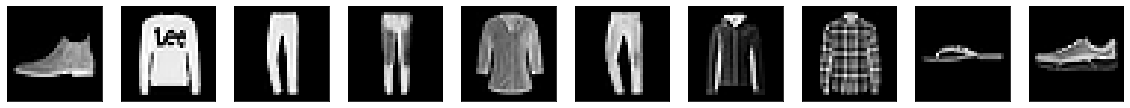

first 10 images + noise


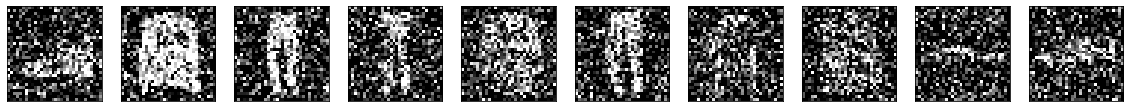

first 10 images reconstructed from denoiser


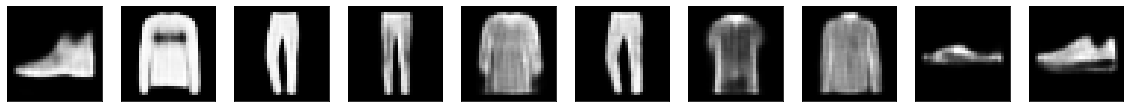

first 10 images encoded and decoded with Autoencoder


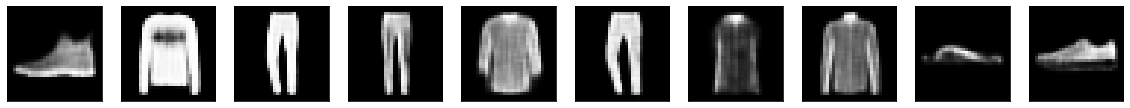

first 10 images encoded and decoded with VAE


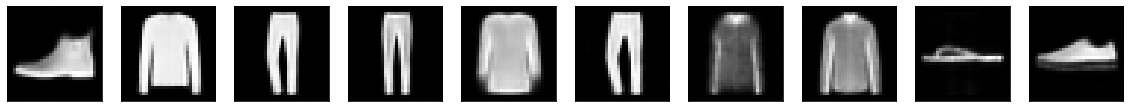

Random generated images from VAE


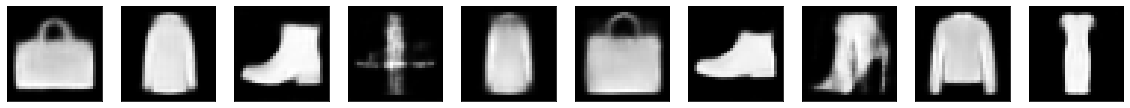

Random Generated images from Autoencoder


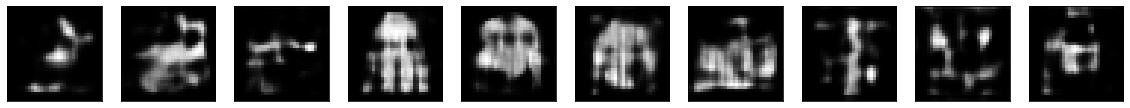

plotting VAE median value for each class


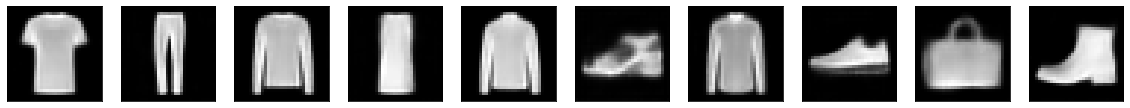

In [0]:
test_loss = autoencoder.evaluate(x_test_fash_mnist_noisy, x_test_fash_mnist, batch_size=batch_size)
print("Test loss:", test_loss)

x_test_fash_mnist_reconstr = autoencoder.predict(x_test_fash_mnist_noisy, batch_size=batch_size)
x_test_fash_mnist_decoder = autoencoder.predict(x_test_fash_mnist, batch_size=batch_size)
x_test_vae = fash_vae.predict(x_test_fash_mnist, batch_size=batch_size)

#VAE GENERATOR
import numpy.random as npr
z = np.array([npr.normal(size=4)])
for i in range (9):
  x = np.array([npr.normal(size=4)])
  z = np.concatenate((x,z))
x_test_vae_generator = fash_mnist_vae_decoder.predict(z)

#DAE GENERATOR
h = np.array([npr.normal(size=128)])
for i in range (9):
  g = np.array([npr.normal(size=128)])
  h = np.concatenate((h,g))
generator_decoder = fash_mnist_dae_decoder.predict(h)


print("first 10 images")
plot_examples(x_test_fash_mnist)
print("first 10 images + noise")
plot_examples(x_test_fash_mnist_noisy)
print("first 10 images reconstructed from denoiser")
plot_examples(x_test_fash_mnist_reconstr)
print("first 10 images encoded and decoded with Autoencoder")
plot_examples(x_test_fash_mnist_decoder)
print("first 10 images encoded and decoded with VAE")
plot_examples(x_test_vae)
print("Random generated images from VAE")
plot_examples(x_test_vae_generator)
print("Random Generated images from Autoencoder")
plot_examples(generator_decoder)
print("plotting VAE median value for each class")
plot_examples_vae_fash_mnist()

In the above image it can be seen that the for the denoising autoencoder it mostly does a similar good job to the same autoencoder while not puting noisy images , it is struggling with the slipper.
It can be seen that the VAE produces good images, but all a little more blurry than the autoencoder.

The generated images from the VAE look like normal clothing items. The random generated items from the autoencoder look like blurry randomness, with while it sometimes guesses something right and actually get's something that very remotely looks like an item.
This difference comes from the fact that if random values are generated for the DAE it will have to get a good value for a combination of 128 neurons, not even batch normalisation can help the model generate images. <br>
But batch normalisation was needed to get some "item" looking results

In the last row the median value for all the means per class is used to generate "average" images for each class.
 


## Task 2.3: Semi-supervised learning
*Perform a thorough evaluation of semi-supervised learning for representations learned with your variational and denoising autoencoders.*

*Guidelines:*
* For various suitable values of $l$, randomly select $l$ instances from the training dataset, these will represent your labelled data and are the only data points that may be used for supervised learning. Make sure to include $l=60000$ (i.e. the entire dataset).
* For each value of $l$, train a few off-the-shelf methods from scikit-learn (e.g. random forest, SVM) as well as a simple multilayer perception (MLP) on representations from both the VAE and DAE, using only the $l$ available labels.
* For each value of $l$, also train an MLP on the original image data, using only the $l$ available labels.
* Visualise your results in a clear way, and report your conclusions. Was it beneficial to use unlabelled data as well as labelled data? Which representations worked best?

### Data
We are going to create all the different datasets to check with the models

In [0]:
#Create the 2 datasets needed for training and show the others
x_train_fash_mnist_autoencoder= fash_mnist_dae_encoder.predict(x_train_fash_mnist, batch_size=batch_size)
x_train_fash_mnist_vae = fash_mnist_vae_encoder.predict(x_train_fash_mnist, batch_size=batch_size)
x_train_fash_mnist_vae = x_train_fash_mnist_vae[0]
x_train_fash_mnist_vae.shape
x_test_fash_mnist_autoencoder = fash_mnist_dae_encoder.predict(x_test_fash_mnist, batch_size=batch_size)
x_test_fash_mnist_vae = fash_mnist_vae_encoder.predict(x_test_fash_mnist, batch_size=batch_size)
x_test_fash_mnist_vae = x_test_fash_mnist_vae[0]
print(x_train_fash_mnist_autoencoder.shape)
print(x_train_fash_mnist.shape)
print(x_train_fash_mnist_vae.shape)
print(x_test_fash_mnist_autoencoder.shape)
print(x_test_fash_mnist_vae.shape)

(60000, 128)
(60000, 32, 32, 1)
(60000, 4)
(10000, 128)
(10000, 4)


The next cell is to create the batches, that are balanced for all classes. The batches we will be choosing are of size:
*  $L=60000$
*  $L=40000$
*  $L=10000$
*  $L=5000$<br>

The next functions create the amount of results per class, so the amount of labels that are put in are 1/10 of what we should end up with.

In [0]:
def getInstancesOriginal(x, y, resultsPerLabel):
    x_result = np.array([])
    y_result = np.array([])
    labels = np.unique(y)
    for label in labels:
        filterArray = y == label
        x_f = x[filterArray]
        y_f = y[filterArray]
        idx = np.random.choice(np.arange(len(y_f)), resultsPerLabel, replace=False)
        x_result = np.append(x_result, x_f[idx])
        y_result = np.append(y_result, y_f[idx])
    x_result = np.reshape(x_result, (len(labels)*resultsPerLabel, x.shape[1], x.shape[2], x.shape[3] ))
    perm = np.random.permutation(len(y_result))
    return x_result[perm], y_result[perm]

def getInstancesEmbedding(x, y, resultsPerLabel):
    x_result = np.array([])
    y_result = np.array([])
    labels = np.unique(y)
    for label in labels:
        filterArray = y == label
        x_f = x[filterArray]
        y_f = y[filterArray]
        idx = np.random.choice(np.arange(len(y_f)), resultsPerLabel, replace=False)
        x_result = np.append(x_result, x_f[idx])
        y_result = np.append(y_result, y_f[idx])
    x_result = np.reshape(x_result, (len(labels)*resultsPerLabel, x.shape[1]))
    perm = np.random.permutation(len(y_result))
    return x_result[perm], y_result[perm]

In [0]:
#Get original images
x_train_fash_mnist_original_60000,y_train_fash_mnist_original_60000 = getInstancesOriginal(x_train_fash_mnist, y_train_fash_mnist, 6000)
x_train_fash_mnist_original_40000,y_train_fash_mnist_original_40000 = getInstancesOriginal(x_train_fash_mnist, y_train_fash_mnist, 4000)
x_train_fash_mnist_original_10000,y_train_fash_mnist_original_10000 = getInstancesOriginal(x_train_fash_mnist, y_train_fash_mnist, 1000)
x_train_fash_mnist_original_5000 ,y_train_fash_mnist_original_5000  = getInstancesOriginal(x_train_fash_mnist, y_train_fash_mnist, 500)
x_train_fash_mnist_original_500  ,y_train_fash_mnist_original_500   = getInstancesOriginal(x_train_fash_mnist, y_train_fash_mnist, 50)

#Get encoder generated images
x_train_fash_mnist_autoencoder_60000,y_train_fash_mnist_autoencoder_60000 = getInstancesEmbedding(x_train_fash_mnist_autoencoder, y_train_fash_mnist, 6000)
x_train_fash_mnist_autoencoder_40000,y_train_fash_mnist_autoencoder_40000 = getInstancesEmbedding(x_train_fash_mnist_autoencoder, y_train_fash_mnist, 4000)
x_train_fash_mnist_autoencoder_10000,y_train_fash_mnist_autoencoder_10000 = getInstancesEmbedding(x_train_fash_mnist_autoencoder, y_train_fash_mnist, 1000)
x_train_fash_mnist_autoencoder_5000 ,y_train_fash_mnist_autoencoder_5000  = getInstancesEmbedding(x_train_fash_mnist_autoencoder, y_train_fash_mnist, 500)
x_train_fash_mnist_autoencoder_500  ,y_train_fash_mnist_autoencoder_500   = getInstancesEmbedding(x_train_fash_mnist_autoencoder, y_train_fash_mnist, 50)
#Get encoder generated images
x_train_fash_mnist_vae_60000,y_train_fash_mnist_vae_60000 = getInstancesEmbedding(x_train_fash_mnist_vae, y_train_fash_mnist, 6000)
x_train_fash_mnist_vae_40000,y_train_fash_mnist_vae_40000 = getInstancesEmbedding(x_train_fash_mnist_vae, y_train_fash_mnist, 4000)
x_train_fash_mnist_vae_10000,y_train_fash_mnist_vae_10000 = getInstancesEmbedding(x_train_fash_mnist_vae, y_train_fash_mnist, 1000)
x_train_fash_mnist_vae_5000 ,y_train_fash_mnist_vae_5000  = getInstancesEmbedding(x_train_fash_mnist_vae, y_train_fash_mnist, 500)
x_train_fash_mnist_vae_500  ,y_train_fash_mnist_vae_500   = getInstancesEmbedding(x_train_fash_mnist_vae, y_train_fash_mnist, 50)

In [0]:
#check the shapes of the datasets
print("original dataset")
print(x_train_fash_mnist_original_60000.shape)
print(x_train_fash_mnist_original_40000.shape)
print(x_train_fash_mnist_original_10000.shape)
print(x_train_fash_mnist_original_5000 .shape)
print(x_train_fash_mnist_original_500  .shape)
print("encoder dataset")
print(x_train_fash_mnist_autoencoder_60000.shape)
print(x_train_fash_mnist_autoencoder_40000.shape)
print(x_train_fash_mnist_autoencoder_10000.shape)
print(x_train_fash_mnist_autoencoder_5000 .shape)
print(x_train_fash_mnist_autoencoder_500  .shape)
print("vae dataset")
print(x_train_fash_mnist_vae_60000.shape)
print(x_train_fash_mnist_vae_40000.shape)
print(x_train_fash_mnist_vae_10000.shape)
print(x_train_fash_mnist_vae_5000 .shape)
print(x_train_fash_mnist_vae_500  .shape)


original dataset
(60000, 32, 32, 1)
(40000, 32, 32, 1)
(10000, 32, 32, 1)
(5000, 32, 32, 1)
(500, 32, 32, 1)
encoder dataset
(60000, 128)
(40000, 128)
(10000, 128)
(5000, 128)
(500, 128)
vae dataset
(60000, 4)
(40000, 4)
(10000, 4)
(5000, 4)
(500, 4)


In [0]:
#some algorithms cannot deal with multidimensional data, so it has to be reshaped into an array
#reshape the datasets
x_train_fash_mnist_original_60000_reshape = x_train_fash_mnist_original_60000.reshape(60000,1024)
x_train_fash_mnist_original_40000_reshape = x_train_fash_mnist_original_40000.reshape(40000,1024)
x_train_fash_mnist_original_10000_reshape = x_train_fash_mnist_original_10000.reshape(10000,1024)
x_train_fash_mnist_original_5000_reshape  = x_train_fash_mnist_original_5000 .reshape(5000,1024)
x_train_fash_mnist_original_500_reshape   = x_train_fash_mnist_original_500  .reshape(500,1024)

#check the shapes of the datasets
print("original dataset")
print(x_train_fash_mnist_original_60000_reshape.shape)
print(x_train_fash_mnist_original_40000_reshape.shape)
print(x_train_fash_mnist_original_10000_reshape.shape)
print(x_train_fash_mnist_original_5000_reshape.shape)
print(x_train_fash_mnist_original_500_reshape.shape)

original dataset
(60000, 1024)
(40000, 1024)
(10000, 1024)
(5000, 1024)
(500, 1024)


In [0]:
#reshaping test set
x_test_fash_mnist_reshape = x_test_fash_mnist.reshape(10000,1024)
x_test_fash_mnist_reshape.shape

(10000, 1024)

In [0]:
data_list = np.array([
    [x_train_fash_mnist_original_60000_reshape       ,y_train_fash_mnist_original_60000           ,x_test_fash_mnist_reshape],
    [x_train_fash_mnist_original_40000_reshape       ,y_train_fash_mnist_original_40000           ,x_test_fash_mnist_reshape],
    [x_train_fash_mnist_original_10000_reshape       ,y_train_fash_mnist_original_10000           ,x_test_fash_mnist_reshape],
    [x_train_fash_mnist_original_5000_reshape        ,y_train_fash_mnist_original_5000            ,x_test_fash_mnist_reshape],
    [x_train_fash_mnist_original_500_reshape         ,y_train_fash_mnist_original_500              ,x_test_fash_mnist_reshape],
    [x_train_fash_mnist_autoencoder_60000            ,y_train_fash_mnist_autoencoder_60000        ,x_test_fash_mnist_autoencoder],
    [x_train_fash_mnist_autoencoder_40000            ,y_train_fash_mnist_autoencoder_40000        ,x_test_fash_mnist_autoencoder],
    [x_train_fash_mnist_autoencoder_10000            ,y_train_fash_mnist_autoencoder_10000        ,x_test_fash_mnist_autoencoder],
    [x_train_fash_mnist_autoencoder_5000             ,y_train_fash_mnist_autoencoder_5000         ,x_test_fash_mnist_autoencoder],
    [x_train_fash_mnist_autoencoder_500              ,y_train_fash_mnist_autoencoder_500          ,x_test_fash_mnist_autoencoder],
    [x_train_fash_mnist_vae_60000                    ,y_train_fash_mnist_vae_60000                ,x_test_fash_mnist_vae],
    [x_train_fash_mnist_vae_40000                    ,y_train_fash_mnist_vae_40000                ,x_test_fash_mnist_vae],
    [x_train_fash_mnist_vae_10000                    ,y_train_fash_mnist_vae_10000                ,x_test_fash_mnist_vae],
    [x_train_fash_mnist_vae_5000                     ,y_train_fash_mnist_vae_5000                 ,x_test_fash_mnist_vae],
    [x_train_fash_mnist_vae_500                      ,y_train_fash_mnist_vae_500                  ,x_test_fash_mnist_vae],
])
print(data_list.shape)

(15, 3)


### Fitting the models

In [0]:
cd /content/gdrive/My Drive/Colab Notebooks/"Assignment 4"/Models/modelling

/content/gdrive/My Drive/Colab Notebooks/Assignment 4/Models/modelling


In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

Function to loop over the datasets fitting each on the type of model

In [0]:
def Looper(modeltype):
  accuracies = np.array([])
  i = 1
  for x,y,test in data_list:
    print(accuracies.shape)
    accuracy, model, name = modeltype(x,y,test)
    save_model(str(str(name)+" Model Number "+str(i)+" Accuracy: "+str(accuracy)),model)
    i+=1
    accuracies = np.append(accuracies,accuracy)
  return accuracies

#### Randomforest classifier

In [0]:
def RandomForest(x,y,test):
  model = RandomForestClassifier(n_estimators=100, max_depth=50, random_state=4)
  model.fit(x, y)
  name = "RandomForest"
  y_predict = model.predict(test)
  accuracy = accuracy_score(y_test_fash_mnist, y_predict)
  return accuracy, model, name

In [0]:
RandomForestAccuracies = Looper(RandomForest)
print(RandomForestAccuracies)

(0,)
 file saved
(1,)
 file saved
(2,)
 file saved
(3,)
 file saved
(4,)
 file saved
(5,)
 file saved
(6,)
 file saved
(7,)
 file saved
(8,)
 file saved
(9,)
 file saved
(10,)
 file saved
(11,)
 file saved
(12,)
 file saved
(13,)
 file saved
(14,)
 file saved
[0.8774 0.8709 0.8526 0.8376 0.774  0.8702 0.8629 0.847  0.8348 0.7788
 0.8106 0.8109 0.7939 0.7894 0.7385]


#### SVM

In [0]:
def SVM(x,y,test):
  model = SVC()
  model.fit(x,y)
  name= "SVM"
  y_predict = model.predict(test)
  accuracy = accuracy_score(y_test_fash_mnist, y_predict)
  return accuracy, model, name

In [0]:
SVMaccuracies = Looper(SVM)
print(SVMaccuracies)

(0,)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


 file saved
(1,)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


 file saved
(2,)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


 file saved
(3,)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


 file saved
(4,)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


 file saved
(5,)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


 file saved
(6,)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


 file saved
(7,)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


 file saved
(8,)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


 file saved
(9,)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


 file saved
(10,)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


 file saved
(11,)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


 file saved
(12,)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


 file saved
(13,)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


 file saved
(14,)
 file saved
[0.8419 0.8327 0.8028 0.7845 0.6901 0.8875 0.8871 0.8641 0.8528 0.7911
 0.8006 0.7995 0.7896 0.7819 0.7543]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


#### Multilayer Perceptron

In [0]:
def MLP(x,y,test):
  model = MLPCreator(x)
  model.fit(x, y , epochs=10, batch_size=32)
  name = "MLP"
  y_predict = model.predict_classes(test, verbose=0, batch_size=32)
  accuracy = accuracy_score(y_test_fash_mnist, y_predict)
  return accuracy, model, name


In [0]:
def MLPCreator(x):
  input_dim = x.shape[1]
  MLP = Sequential()
  MLP.add(Dense(128, activation='relu', input_dim=(input_dim)))
  MLP.add(BatchNormalization())
  MLP.add(Dropout(0.5))
  MLP.add(Dense(128, activation='relu'))
  MLP.add(BatchNormalization())
  MLP.add(Dense(10,activation='softmax'))
  MLP.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return(MLP)

In [0]:
MLPaccuracies = Looper(MLP)
print(MLPaccuracies)

(0,)
Epoch 1/10
60000/60000 [==============================] - 18s 293us/step - loss: 0.6310 - acc: 0.7738
Epoch 2/10
60000/60000 [==============================] - 13s 210us/step - loss: 0.5182 - acc: 0.8138
Epoch 3/10
60000/60000 [==============================] - 13s 210us/step - loss: 0.4836 - acc: 0.8267
Epoch 4/10
60000/60000 [==============================] - 13s 210us/step - loss: 0.4659 - acc: 0.8327
Epoch 5/10
60000/60000 [==============================] - 13s 211us/step - loss: 0.4463 - acc: 0.8398
Epoch 6/10
60000/60000 [==============================] - 13s 211us/step - loss: 0.4386 - acc: 0.8421
Epoch 7/10
60000/60000 [==============================] - 13s 211us/step - loss: 0.4282 - acc: 0.8458
Epoch 8/10
60000/60000 [==============================] - 13s 210us/step - loss: 0.4262 - acc: 0.8444
Epoch 9/10
60000/60000 [==============================] - 13s 209us/step - loss: 0.4170 - acc: 0.8497
Epoch 10/10
60000/60000 [==============================] - 13s 210us/step - l

### Evaluation

**Motivation & Conclusions:** *Explain your analysis, and draw conclusions:*

The approach is chosen to have very generic models for the easy models.

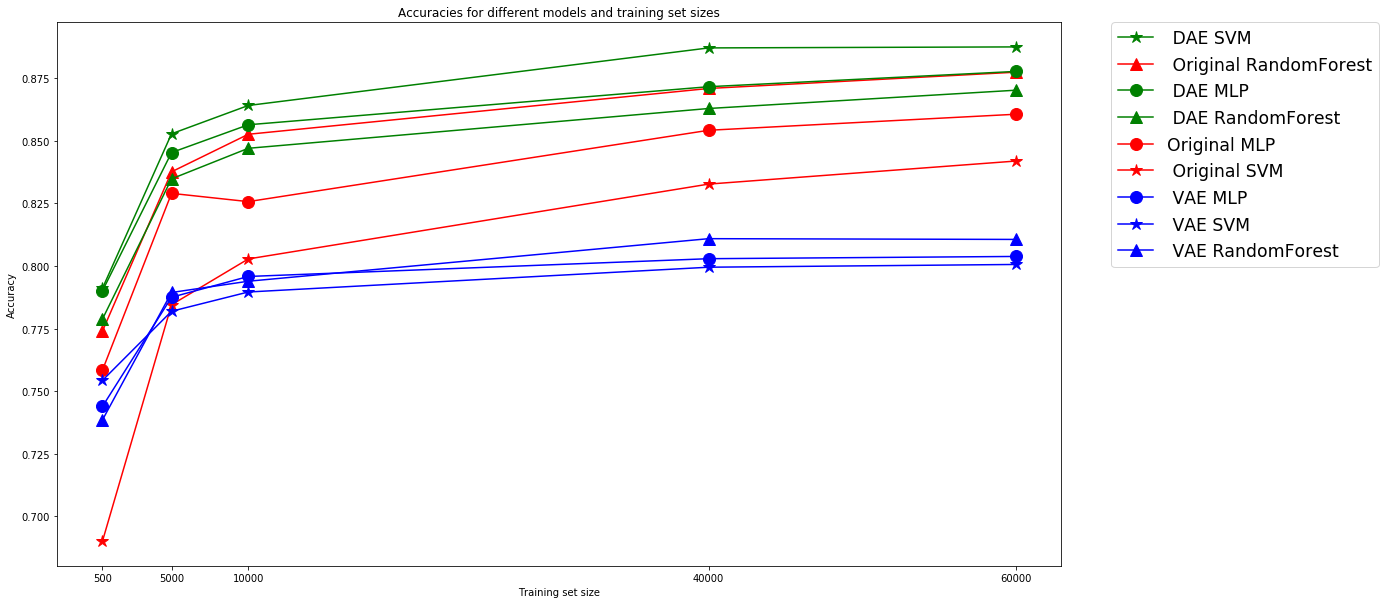

In [0]:
# MLP = [0.8614, 0.8474, 0.8274, 0.822 , 0.8724, 0.8683, 0.8528, 0.8424, 0.8003, 0.7963, 0.7847, 0.7841]
# SVM = [0.8419, 0.8325, 0.8026, 0.7825, 0.886 , 0.8809, 0.861 , 0.8476, 0.7894, 0.7886, 0.7806, 0.773]
# RF =  [0.8759, 0.8703, 0.846 , 0.8357, 0.8664, 0.8624, 0.8429, 0.8313, 0.8023, 0.7983, 0.7867, 0.7811]
MLP = MLPaccuracies
SVM = SVMaccuracies
RF = RandomForestAccuracies

MLP_orr = np.array([
    [60000, MLP[0]],
    [40000, MLP[1]],
    [10000, MLP[2]],
    [5000, MLP[3]],
    [500, MLP[4]]
])
x_MLPorr, y_MLPorr = MLP_orr.T

MLP_dae = np.array([
    [60000, MLP[5]],
    [40000, MLP[6]],
    [10000, MLP[7]],
    [5000, MLP[8]],
    [500, MLP[9]],
])
x_MLPdae, y_MLPdae = MLP_dae.T

MLP_vae = np.array([
    [60000, MLP[10]],
    [40000, MLP[11]],
    [10000, MLP[12]],
    [5000, MLP[13]],
    [500, MLP[14]]
])
x_MLPvae, y_MLPvae = MLP_vae.T


SVM_orr = np.array([
    [60000, SVM[0]],
    [40000, SVM[1]],
    [10000, SVM[2]],
    [5000, SVM[3]],
    [500, SVM[4]]
])
x_SVMorr, y_SVMorr = SVM_orr.T

SVM_dae = np.array([
    [60000, SVM[5]],
    [40000, SVM[6]],
    [10000, SVM[7]],
    [5000, SVM[8]],
    [500, SVM[9]],
])
x_SVMdae, y_SVMdae = SVM_dae.T

SVM_vae = np.array([
    [60000, SVM[10]],
    [40000, SVM[11]],
    [10000, SVM[12]],
    [5000, SVM[13]],
    [500, SVM[14]],
])
x_SVMvae, y_SVMvae = SVM_vae.T


RF_orr = np.array([
    [60000, RF[0]],
    [40000, RF[1]],
    [10000, RF[2]],
    [5000, RF[3]],
    [500, RF[4]],
])
x_RForr, y_RForr = RF_orr.T
    
RF_dae = np.array([
    [60000, RF[5]],
    [40000, RF[6]],
    [10000, RF[7]],
    [5000, RF[8]],
    [500, RF[9]],
])
x_RFdae, y_RFdae = RF_dae.T
    
RF_vae = np.array([
    [60000, RF[10]],
    [40000, RF[11]],
    [10000, RF[12]],
    [5000, RF[13]],
    [500, RF[14]],
])
x_RFvae, y_RFvae = RF_vae.T


h = 12

plt.figure(figsize=(18,10))
plt.plot(x_SVMdae, y_SVMdae, color='green', marker='*',markersize=h , label =" DAE SVM")
plt.plot(x_RForr, y_RForr, color='r', marker='^',markersize=h, label =" Original RandomForest")
plt.plot(x_MLPdae, y_MLPdae, color='green', marker='o',markersize=h, label =" DAE MLP") 
plt.plot(x_RFdae, y_RFdae, color='green', marker='^',markersize=h, label =" DAE RandomForest") 
plt.plot(x_MLPorr, y_MLPorr, color='r', marker='o', markersize=h, label="Original MLP ")
plt.plot(x_SVMorr, y_SVMorr, color='r', marker='*',markersize=h, label =" Original SVM")
plt.plot(x_MLPvae, y_MLPvae, color='blue', marker='o',markersize=h, label =" VAE MLP")
plt.plot(x_SVMvae, y_SVMvae, color='blue', marker='*',markersize=h, label =" VAE SVM")
plt.plot(x_RFvae, y_RFvae, color='blue', marker='^',markersize=h, label =" VAE RandomForest") 

plt.title('Accuracies for different models and training set sizes')
plt.ylabel('Accuracy')
plt.xlabel('Training set size')
#plt.ylim([0, 1])
plt.xticks([60000, 40000, 10000, 5000, 500])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize="xx-large")


It can be seen that overall the SVM trained on the embeddings of the autoencoder performed the best, this is probably due to the fact that the embedding space is not too large, but still large enough to make an impact distinction. <br>
It can also be seen that all prediction on representations from the VAE embedding space are performing less than the other representations, this is likely due to the simplicity of this latent space. Although it must be said that this is the most compact representation, so I was expecting a far worse result. <br>

It is interesting to see how adding more data has a significant result to all models, but the increase in the SVM on the original data is interesting.